In [4]:
from w2v import movieFeedbackWord2Vec
from sklearn.model_selection import train_test_split

w2v_skipgram = movieFeedbackWord2Vec()
w2v_skipgram.load("vec_models/skipgram_model.bin")
w2v_skipgram.most_similar("film")

[('movie', 0.8439738154411316),
 ('flick', 0.6341231465339661),
 ('cinema', 0.6087235808372498),
 ('picture', 0.5930522084236145),
 ('masterpiece', 0.5865710973739624),
 ('completists', 0.5714558959007263),
 ('overlooked', 0.554018497467041),
 ('effort', 0.5490061640739441),
 ('here', 0.5461225509643555),
 ('genre', 0.5376661419868469)]

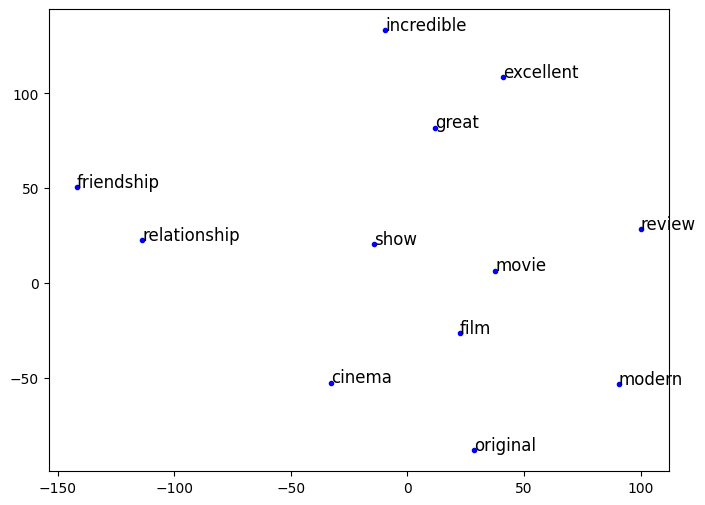

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Chọn các từ bạn muốn vẽ
selected_words = ["film", "review", "original", "relationship",
                  "modern", "movie", "show", "friendship",
                  "great", "excellent", "incredible", "cinema"]

# Lấy vector của các từ từ mô hình
vectors = np.array([w2v_skipgram.get_vector(word) for word in selected_words])

# Giảm chiều dữ liệu về 2 chiều bằng t-SNE
tsne = TSNE(n_components=2, perplexity=5 ,random_state=42)
vectors_2d = tsne.fit_transform(vectors)

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], marker='.', color='b')

# Hiển thị tên của các từ
for i, word in enumerate(selected_words):
    plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]), fontsize=12)

plt.show()

In [6]:
print(w2v_skipgram.get_vectors().shape)
w2v_skipgram.get_vectors()

(10667, 120)


array([[-0.03728084, -0.10921527,  0.06051791, ...,  0.01326829,
         0.15513389,  0.07351569],
       [-0.09344961, -0.06344727, -0.02836427, ..., -0.03629223,
         0.0371445 ,  0.06025255],
       [-0.04873816,  0.16916586,  0.01989446, ...,  0.16592872,
         0.20066333, -0.08139649],
       ...,
       [-0.03436405, -0.12919354,  0.01379176, ...,  0.05752142,
        -0.10436366,  0.01272653],
       [-0.15581058, -0.28898403,  0.05125132, ..., -0.14493383,
        -0.13534327,  0.10168457],
       [ 0.11801639, -0.0695557 , -0.2835569 , ...,  0.11915883,
         0.26406673, -0.327728  ]], dtype=float32)

In [7]:
import pickle as pkl
words = dict()
    
for word in w2v_skipgram.get_vocab():
    words[word] = w2v_skipgram.get_vector(word)
    
with open("sentiment_analysis/words_dict.pkl", 'wb') as file:
    pkl.dump(words, file)

In [8]:
# Load Vectorizer
with open("sentiment_analysis/words_dict.pkl", "rb") as file:
    words = pkl.load(file)

In [9]:
from nltk.tokenize import word_tokenize
from sentiment_analysis.preprocessing import processtext

def tokenize_vietnamese_sentence(sentence):
    return word_tokenize(processtext(sentence.lower()))

def sent2vec(message, word_dict = words):
    tokens = tokenize_vietnamese_sentence(message)
    vectors = []
    
    for token in tokens:
        if token not in word_dict.keys():
            continue
        token_vector = word_dict[token]
        vectors.append(token_vector)
    return np.array(vectors, dtype=float)

In [10]:
import pandas as pd
df = pd.read_csv("sentiment_analysis/IMDB Dataset.csv")

df["sentiment"] = df["sentiment"].replace('positive', 1)
df["sentiment"] = df["sentiment"].replace('negative', 0)
X_train, X_temp, y_train, y_temp = train_test_split(df["review"], df["sentiment"], test_size=0.3, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.66, random_state=42)

C:\Users\thien\AppData\Local\Temp\ipykernel_11384\1611810459.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["sentiment"] = df["sentiment"].replace('negative', 0)


In [11]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_dev = X_dev.reset_index(drop=True)
y_dev = y_dev.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [12]:
def df_to_X_y(X):  
    all_word_vector_sequences = []
    
    for message in X:
      message_as_vector_seq = sent2vec(message)
      if message_as_vector_seq.shape[0] == 0:
        message_as_vector_seq = np.zeros(shape=(1, 120))

      all_word_vector_sequences.append(message_as_vector_seq)
    
    return all_word_vector_sequences

In [13]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\thien\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thien\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thien\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
from copy import deepcopy

# Create sequences padding for X
def pad_sequences(X):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = 150 - x_seq_len
    if sequence_length_difference > 0:
      pad = np.zeros(shape=(sequence_length_difference, 120))
      X_copy[i] = np.concatenate([x, pad])
    else:
      X_copy[i] = x[0:150]
  
  return np.array(X_copy).astype(float)

In [15]:
X_train = df_to_X_y(X_train)
X_train = pad_sequences(X_train)

X_train.shape

(35000, 150, 120)

In [16]:
X_dev = df_to_X_y(X_dev)
X_dev = pad_sequences(X_dev)

X_dev.shape

(5100, 150, 120)

In [17]:
X_test = df_to_X_y(X_test)
X_test = pad_sequences(X_test)

X_test.shape

(9900, 150, 120)

In [18]:
from keras import layers
from keras.models import Sequential

model = Sequential([])

model.add(layers.Input(shape=(150, 120)))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.LSTM(32, return_sequences=True))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(2, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 150, 128)          127488    
                                                                 
 dropout_3 (Dropout)         (None, 150, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 150, 64)           49408     
                                                                 
 dropout_4 (Dropout)         (None, 150, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 150, 32)           12416     
                                                                 
 dropout_5 (Dropout)         (None, 150, 32)           0         
                                                                 
 flatten_1 (Flatten)         (None, 4800)             

In [20]:
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import AUC
from keras.callbacks import ModelCheckpoint

# Import the legacy optimizer
from keras.optimizers import legacy

cp = ModelCheckpoint('lstm_model/', save_best_only=True)

# Use the legacy Adam optimizer
optimizer = legacy.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
frequencies = pd.value_counts(y_train)

frequencies

C:\Users\thien\AppData\Local\Temp\ipykernel_11384\3918391452.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  frequencies = pd.value_counts(y_train)


sentiment
0    17589
1    17411
Name: count, dtype: int64

In [22]:
weights = {0: frequencies.sum() / frequencies[0], 1: frequencies.sum() / frequencies[1]}
weights

{0: 1.9898800386605264, 1: 2.010223421974614}

In [23]:
model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=20, callbacks=[cp], class_weight=weights)

Epoch 1/20


1094/1094 [==============================] - ETA: 0s - loss: 1.0008 - accuracy: 0.7495INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


1094/1094 [==============================] - 224s 199ms/step - loss: 1.0008 - accuracy: 0.7495 - val_loss: 0.3151 - val_accuracy: 0.8712
Epoch 2/20
1094/1094 [==============================] - 231s 211ms/step - loss: 0.6199 - accuracy: 0.8728 - val_loss: 0.3210 - val_accuracy: 0.8686
Epoch 3/20
1094/1094 [==============================] - ETA: 0s - loss: 0.5752 - accuracy: 0.8833INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


1094/1094 [==============================] - 247s 225ms/step - loss: 0.5752 - accuracy: 0.8833 - val_loss: 0.2976 - val_accuracy: 0.8845
Epoch 4/20
1094/1094 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.8925INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


1094/1094 [==============================] - 257s 235ms/step - loss: 0.5312 - accuracy: 0.8925 - val_loss: 0.2829 - val_accuracy: 0.8847
Epoch 5/20
1094/1094 [==============================] - ETA: 0s - loss: 0.4997 - accuracy: 0.9005INFO:tensorflow:Assets written to: lstm_model\assets


INFO:tensorflow:Assets written to: lstm_model\assets


1094/1094 [==============================] - 253s 231ms/step - loss: 0.4997 - accuracy: 0.9005 - val_loss: 0.2824 - val_accuracy: 0.8855
Epoch 6/20
1094/1094 [==============================] - 251s 229ms/step - loss: 0.4573 - accuracy: 0.9085 - val_loss: 0.2910 - val_accuracy: 0.8857
Epoch 7/20
1094/1094 [==============================] - 248s 227ms/step - loss: 0.4203 - accuracy: 0.9181 - val_loss: 0.3072 - val_accuracy: 0.8831
Epoch 8/20
1094/1094 [==============================] - 235s 215ms/step - loss: 0.3882 - accuracy: 0.9259 - val_loss: 0.3097 - val_accuracy: 0.8806
Epoch 9/20
1094/1094 [==============================] - 223s 203ms/step - loss: 0.3515 - accuracy: 0.9341 - val_loss: 0.3378 - val_accuracy: 0.8780
Epoch 10/20
1094/1094 [==============================] - 229s 209ms/step - loss: 0.3293 - accuracy: 0.9387 - val_loss: 0.3493 - val_accuracy: 0.8724
Epoch 11/20
1094/1094 [==============================] - 214s 196ms/step - loss: 0.3362 - accuracy: 0.9360 - val_loss: 0.3

In [24]:
from keras.models import load_model

# Assuming you have trained and saved your model as follows
model.save("lstm_model/lstm_model.h5")

C:\Users\thien\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

## Classification Report

---

In [25]:
test_predictions = (model.predict(X_test))

Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000001EFD86DB760>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000001EFD86DB760>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x000001EFD86DB760>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
310/310 [==============================] - 39s 117ms/step


In [26]:
test_predictions

array([[0.39564788, 0.60374516],
       [0.92597413, 0.07366187],
       [0.9015161 , 0.09810957],
       ...,
       [0.07775664, 0.92220825],
       [0.22730696, 0.772704  ],
       [0.35964784, 0.6415569 ]], dtype=float32)

In [27]:
# Convert one-hot encoded predictions to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

print(predicted_labels)

[1 0 0 ... 1 1 1]


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score

print("Report: \n",classification_report(y_test,predicted_labels))
print("Confusion Matrix: \n",confusion_matrix(y_test,predicted_labels))
print("Precision: ",precision_score(y_test,predicted_labels,average="weighted"))
print("Recall: ",recall_score(y_test,predicted_labels,average="weighted"))
print("F1-Score: ",f1_score(y_test,predicted_labels,average="weighted"))
print("Accuracy: ",accuracy_score(y_test,predicted_labels))

Report: 
               precision    recall  f1-score   support

           0       0.89      0.85      0.87      4923
           1       0.86      0.89      0.87      4977

    accuracy                           0.87      9900
   macro avg       0.87      0.87      0.87      9900
weighted avg       0.87      0.87      0.87      9900

Confusion Matrix: 
 [[4201  722]
 [ 545 4432]]
Precision:  0.8724716740706212
Recall:  0.872020202020202
F1-Score:  0.8719667833846361
Accuracy:  0.872020202020202


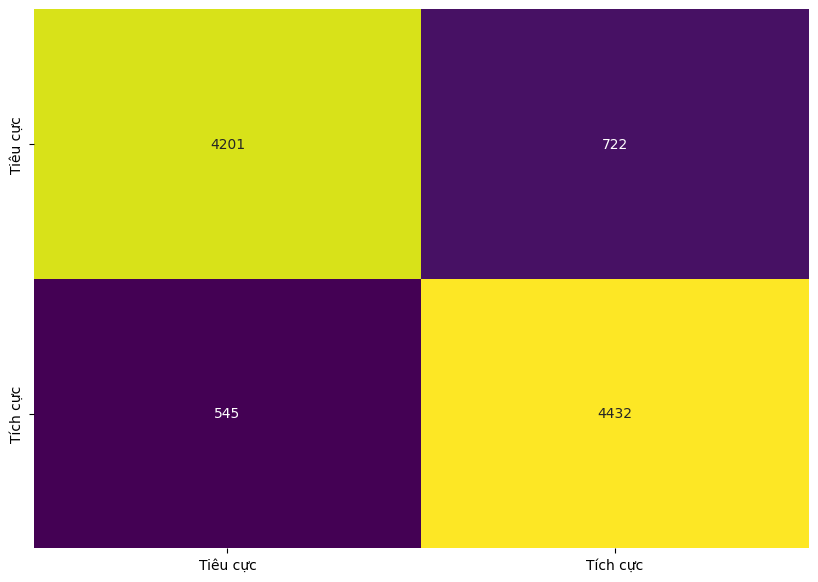

In [29]:
import seaborn as sn
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test,predicted_labels)
plt.figure(figsize = (10,7))
sn.heatmap(conf_matrix, annot=True, fmt="d",cmap="viridis", cbar=False,
                 xticklabels=["Tiêu cực", "Tích cực"], yticklabels=["Tiêu cực", "Tích cực"])
plt.show()

---

## Prediction

---

In [30]:
desired_sequence_length = 150

In [31]:
from keras.models import load_model
lstm_model = load_model("lstm_model/lstm_model.h5")

In [51]:
sentence = "Film quite normal, but it's good"
def pad_sequence_sentence(sentence):
    array = sent2vec(sentence)
    arr_seq_len = array.shape[0]
    sequence_length_difference = desired_sequence_length - arr_seq_len
        
    pad = np.zeros(shape=(sequence_length_difference, 120))

    array = np.array(np.concatenate([array, pad]))
    array = np.expand_dims(array, axis=0)
    return array.astype(float)
array = pad_sequence_sentence(sentence)
array.shape

(1, 150, 120)

In [52]:
prediction = np.argmax(lstm_model.predict(array))
print("Sentiment: ", prediction)

1/1 [==============================] - 0s 50ms/step
Sentiment:  1
